In [18]:
import torch
from torch import nn
import numpy as np
from stacked_mnist import StackedMNISTData, DataMode
from tensorflow import keras
from torchsummary import summary

In [19]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 9, 3, stride=2, padding=1, groups=3),
            # nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(9, 18, 3, stride=2, padding=1, groups=3),
            nn.BatchNorm2d(18),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(18, 36, 3, stride=2, padding=0, groups=3),
            # nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(36*3*3, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim),
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [20]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 36*3*3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(36, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(36, 18, 3, stride=2, padding=0, output_padding=0, groups=3),
            nn.BatchNorm2d(18),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(18, 9, 3, stride=2, padding=1, output_padding=1, groups=3),
            nn.BatchNorm2d(9),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(9, 3, 3, stride=2, padding=1, output_padding=1, groups=3)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [21]:
d = 24
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
#print(encoder)
#print(decoder)
summary(encoder, (3, 28, 28))
summary(decoder, (24,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 14, 14]              90
              ReLU-2            [-1, 9, 14, 14]               0
            Conv2d-3             [-1, 18, 7, 7]             504
       BatchNorm2d-4             [-1, 18, 7, 7]              36
              ReLU-5             [-1, 18, 7, 7]               0
            Conv2d-6             [-1, 36, 3, 3]           1,980
              ReLU-7             [-1, 36, 3, 3]               0
           Flatten-8                  [-1, 324]               0
            Linear-9                  [-1, 128]          41,600
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 24]           3,096
Total params: 47,306
Trainable params: 47,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [22]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [23]:
### Training function
def train_epoch(encoder, decoder, loss_fn, optimizer, x):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []

    # Encode data
    encoded_data = encoder(x)
    # Decode data
    decoded_data = decoder(encoded_data)
    # Evaluate loss
    loss = loss_fn(decoded_data, x)
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.data))
    train_loss.append(loss.detach().numpy())

    return train_loss

In [24]:
### Testing function
def test_epoch(encoder, decoder, loss_fn, x):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        # Encode data
        encoded_data = encoder(x)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Append the network output and the original image to the lists
        conc_out.append(decoded_data)
        conc_label.append(x)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [25]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

(60000, 3)
(10000, 3)


In [26]:
import matplotlib.pyplot as plt
import random 
num_epochs = 1000
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   img_train, labels_train = generator.get_random_batch(training=True)
   img_test, labels_test = generator.get_random_batch(training=False)
   print(img_train.shape)

   #img_train = np.expand_dims(img_train, axis=-1)
   #img_train = np.swapaxes(img_train, 1, -1)
   #img_test = np.expand_dims(img_test, axis=-1)
   #img_test = np.swapaxes(img_test, 1, -1)
   img_train = torch.tensor(img_train)
   img_train = img_train.type(torch.FloatTensor)
   img_test = torch.tensor(img_test)
   img_test = img_test.type(torch.FloatTensor)
   train_loss = train_epoch(encoder,decoder,loss_fn,optim, img_train)
   val_loss = test_epoch(encoder,decoder,loss_fn, img_test)
   print(f"Epoch {epoch+1}/{num_epochs} train loss: {train_loss}, val loss: {val_loss}")
   #print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)

	 partial train loss (single batch): 0.255736
Epoch 1/1000 train loss: [array(0.25573647, dtype=float32)], val loss: 0.24542362987995148
	 partial train loss (single batch): 0.253239
Epoch 2/1000 train loss: [array(0.25323942, dtype=float32)], val loss: 0.2449091225862503
	 partial train loss (single batch): 0.250756
Epoch 3/1000 train loss: [array(0.25075552, dtype=float32)], val loss: 0.24417726695537567
	 partial train loss (single batch): 0.249264
Epoch 4/1000 train loss: [array(0.2492645, dtype=float32)], val loss: 0.24388237297534943
	 partial train loss (single batch): 0.247940
Epoch 5/1000 train loss: [array(0.2479396, dtype=float32)], val loss: 0.24335354566574097
	 partial train loss (single batch): 0.246544
Epoch 6/1000 train loss: [array(0.24654414, dtype=float32)], val loss: 0.2429407835006714
	 partial train loss (single batch): 0.245297
Epoch 7/1000 train loss: [array(0.24529704, dtype=float32)], val loss: 0.24267423152923584
	 partial train loss (single batch): 0.244143

KeyboardInterrupt: 

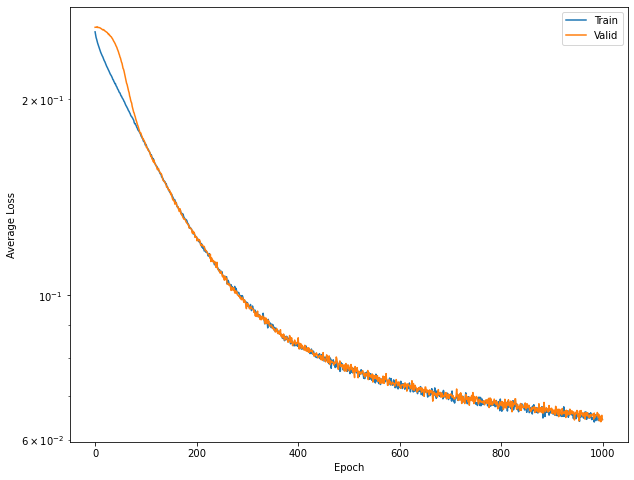

In [270]:
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

torch.Size([100, 3, 28, 28])


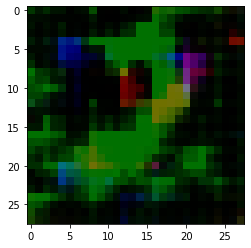

In [361]:
z = np.random.randn(100, d)
z = torch.Tensor(z)
with torch.no_grad():
    x_hat = decoder(z)
print(x_hat.shape)
x = np.array(x_hat[0])
#x = x[2, :, :]
#x = x.reshape((28, 28))
x = np.swapaxes(x, 0, 1)
x = np.swapaxes(x, 1, 2)

plt.imshow(x)

r = x[:, :, 0]
g = x[:, :, 1]
b = x[:, :, 2]

#plt.imshow(b)